# Channel Flow (Steady) DEMO code

This notebook demonstrates solving steady-state channel flow (uniform inlet) using Physics-Informed Neural Networks (PINNs).

In [1]:
import deepflow as df
print("Deepflow is runned on:", df.device) # to change to cpu use df.device = 'cpu'
df.manual_seed(69) # for reproducibility

Deepflow is runned on: cuda


## 1. Define Geometry Domain
Set up the computational domain: a rectangle with a circular obstacle (cylinder). This defines the area for simulation.

In [2]:
circle = df.geometry.circle(0.2, 0.2, 0.05)
rectangle = df.geometry.rectangle([0,1.1], [0,0.41])
area = rectangle - circle

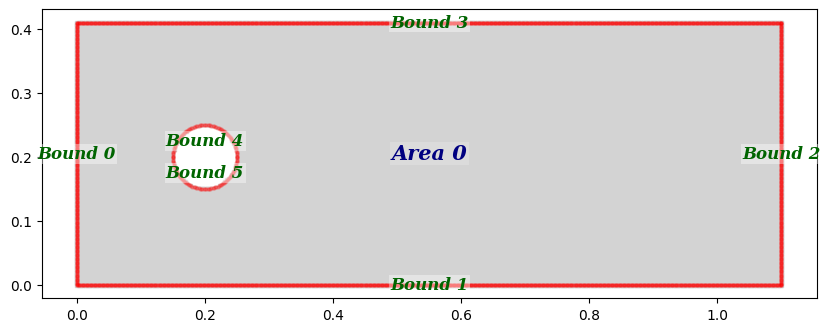

In [3]:
domain = df.domain(area, circle.bound_list)
domain.show_setup()

## 2. Define Physics
Define the Navier-Stokes equations for fluid flow and apply boundary conditions (e.g., no-slip walls, inlet velocity).

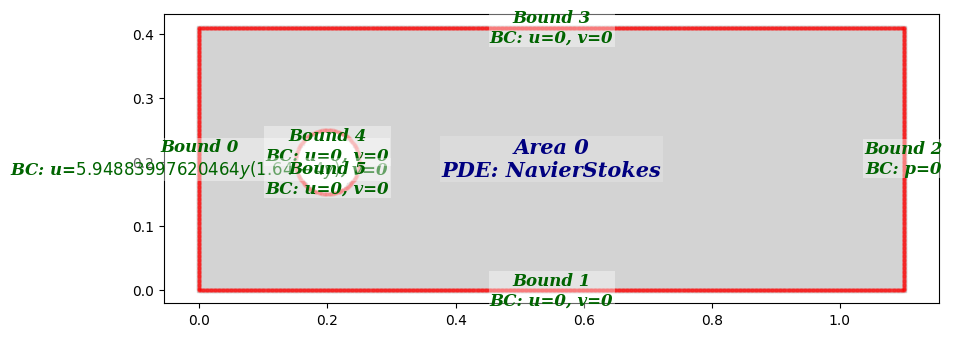

In [4]:
domain.bound_list[0].define_bc({'u': ['y', lambda x:  4*1*(0.41-x)*x/0.41**2], 'v': 0})
domain.bound_list[1].define_bc({'u': 0,'v': 0})
domain.bound_list[2].define_bc({'p': 0})
domain.bound_list[3].define_bc({'u': 0,'v': 0})
domain.bound_list[4].define_bc({'u': 0, 'v': 0})
domain.bound_list[5].define_bc({'u': 0, 'v': 0})
domain.area_list[0].define_pde(df.NavierStokes(U=1, L=1, mu=0.02, rho=1))
domain.show_setup()


Sample initial points for training.

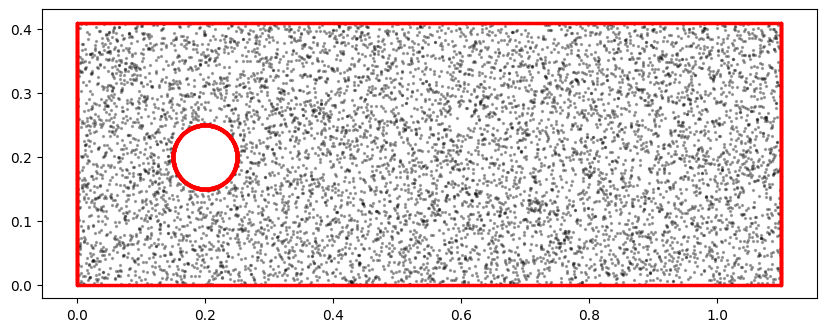

In [5]:
domain.sampling_lhs(bound_sampling_res=[2000, 2000, 2000, 2000, 2000, 2000], area_sampling_res=[8000])
domain.show_coordinates(display_physics=False)

## 3. Train the PINN model

Define how collocation points are sampled during training.

In [6]:
def do_in_adam(epoch, model):
    return
    if epoch % 500 == 0 and epoch > 0:
        domain.sampling_R3(bound_sampling_res=[2000, 2000, 2000, 2000, 2000, 2000], area_sampling_res=[8000])
        print(domain)
        
def do_in_lbfgs(epoch, model):
    if epoch % 100 == 0 and epoch > 0:
        domain.sampling_R3(bound_sampling_res=[2000, 2000, 2000, 2000, 2000, 2000], area_sampling_res=[8000])
        print(domain)

Train the model using Adam for initial training (faster convergence).

In [7]:
model0 = df.PINN(width=50, length=5, input_vars=['x','y'], output_vars=['u','v','p'])

# Train the model
model1, model1best = model0.train_adam(
    learning_rate=0.004,
    epochs=2000,
    calc_loss=df.calc_loss_simple(domain),
    threshold_loss=0.0005,
    do_between_epochs=do_in_adam)

Epoch: 1, total_loss: 0.73839, bc_loss: 0.73786, pde_loss: 0.00053
Epoch: 200, total_loss: 0.22484, bc_loss: 0.20131, pde_loss: 0.02353
Epoch: 400, total_loss: 0.20721, bc_loss: 0.18205, pde_loss: 0.02516
Epoch: 600, total_loss: 0.19249, bc_loss: 0.16782, pde_loss: 0.02467
Epoch: 800, total_loss: 0.18385, bc_loss: 0.16155, pde_loss: 0.02230
Epoch: 1000, total_loss: 0.17726, bc_loss: 0.15721, pde_loss: 0.02004
Epoch: 1200, total_loss: 0.17291, bc_loss: 0.15420, pde_loss: 0.01871
Epoch: 1400, total_loss: 0.18417, bc_loss: 0.13858, pde_loss: 0.04559
Epoch: 1600, total_loss: 0.17927, bc_loss: 0.13075, pde_loss: 0.04852
Epoch: 1800, total_loss: 0.13608, bc_loss: 0.10543, pde_loss: 0.03065
Epoch: 2000, total_loss: 0.11410, bc_loss: 0.09796, pde_loss: 0.01614


Refine the model using LBFGS for higher precision.

In [8]:
# Train the model
model2 = model1best.train_lbfgs(
    calc_loss=df.calc_loss_simple(domain),
    epochs=1000,
    threshold_loss=0.00001,
    do_between_epochs=do_in_lbfgs)

Epoch: 2000, total_loss: 0.10376, bc_loss: 0.09090, pde_loss: 0.01285
Epoch: 2050, total_loss: 0.00755, bc_loss: 0.00257, pde_loss: 0.00498
number of bound : ['0: 3211', '1: 2961', '2: 2520', '3: 2459', '4: 2917', '5: 2927']
number of area : ['0: 10355']
Epoch: 2100, total_loss: 0.00489, bc_loss: 0.00068, pde_loss: 0.00421
Epoch: 2150, total_loss: 0.00145, bc_loss: 0.00025, pde_loss: 0.00120
number of bound : ['0: 4032', '1: 3645', '2: 3017', '3: 2915', '4: 4097', '5: 4088']
number of area : ['0: 12388']
Epoch: 2200, total_loss: 0.00231, bc_loss: 0.00019, pde_loss: 0.00213
Epoch: 2250, total_loss: 0.00095, bc_loss: 0.00017, pde_loss: 0.00078
number of bound : ['0: 4815', '1: 4261', '2: 3543', '3: 3642', '4: 5051', '5: 5063']
number of area : ['0: 14243']
Epoch: 2300, total_loss: 0.00086, bc_loss: 0.00015, pde_loss: 0.00071
Epoch: 2350, total_loss: 0.00064, bc_loss: 0.00012, pde_loss: 0.00052
number of bound : ['0: 5425', '1: 4753', '2: 4448', '3: 4311', '4: 5891', '5: 5885']
number of 

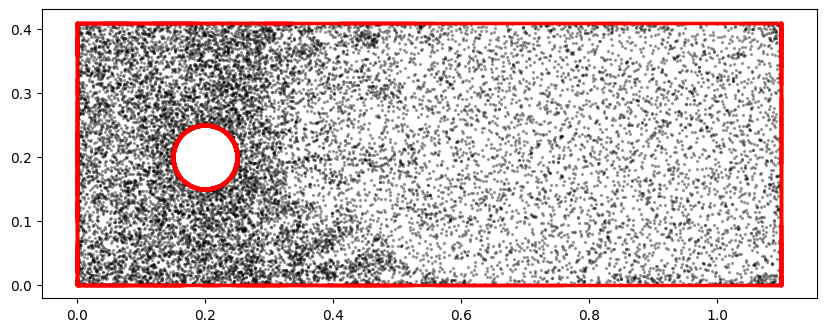

In [9]:
domain.show_coordinates()

Save or Load the model for later use

In [10]:
model2.save_as_pickle()
model2.load_from_pickle("model.pkl")

## 4. Visualization

### 4.1 Visualize area

In [11]:
# Create object for evaluation
area_eval = domain.area_list[0].evaluate(model2)
# Sampling uniform points
area_eval.sampling_area([300, 150])

In [12]:
area_eval["velocity_magnitude"] = (area_eval["u"]**2 + area_eval["v"]**2)**0.5

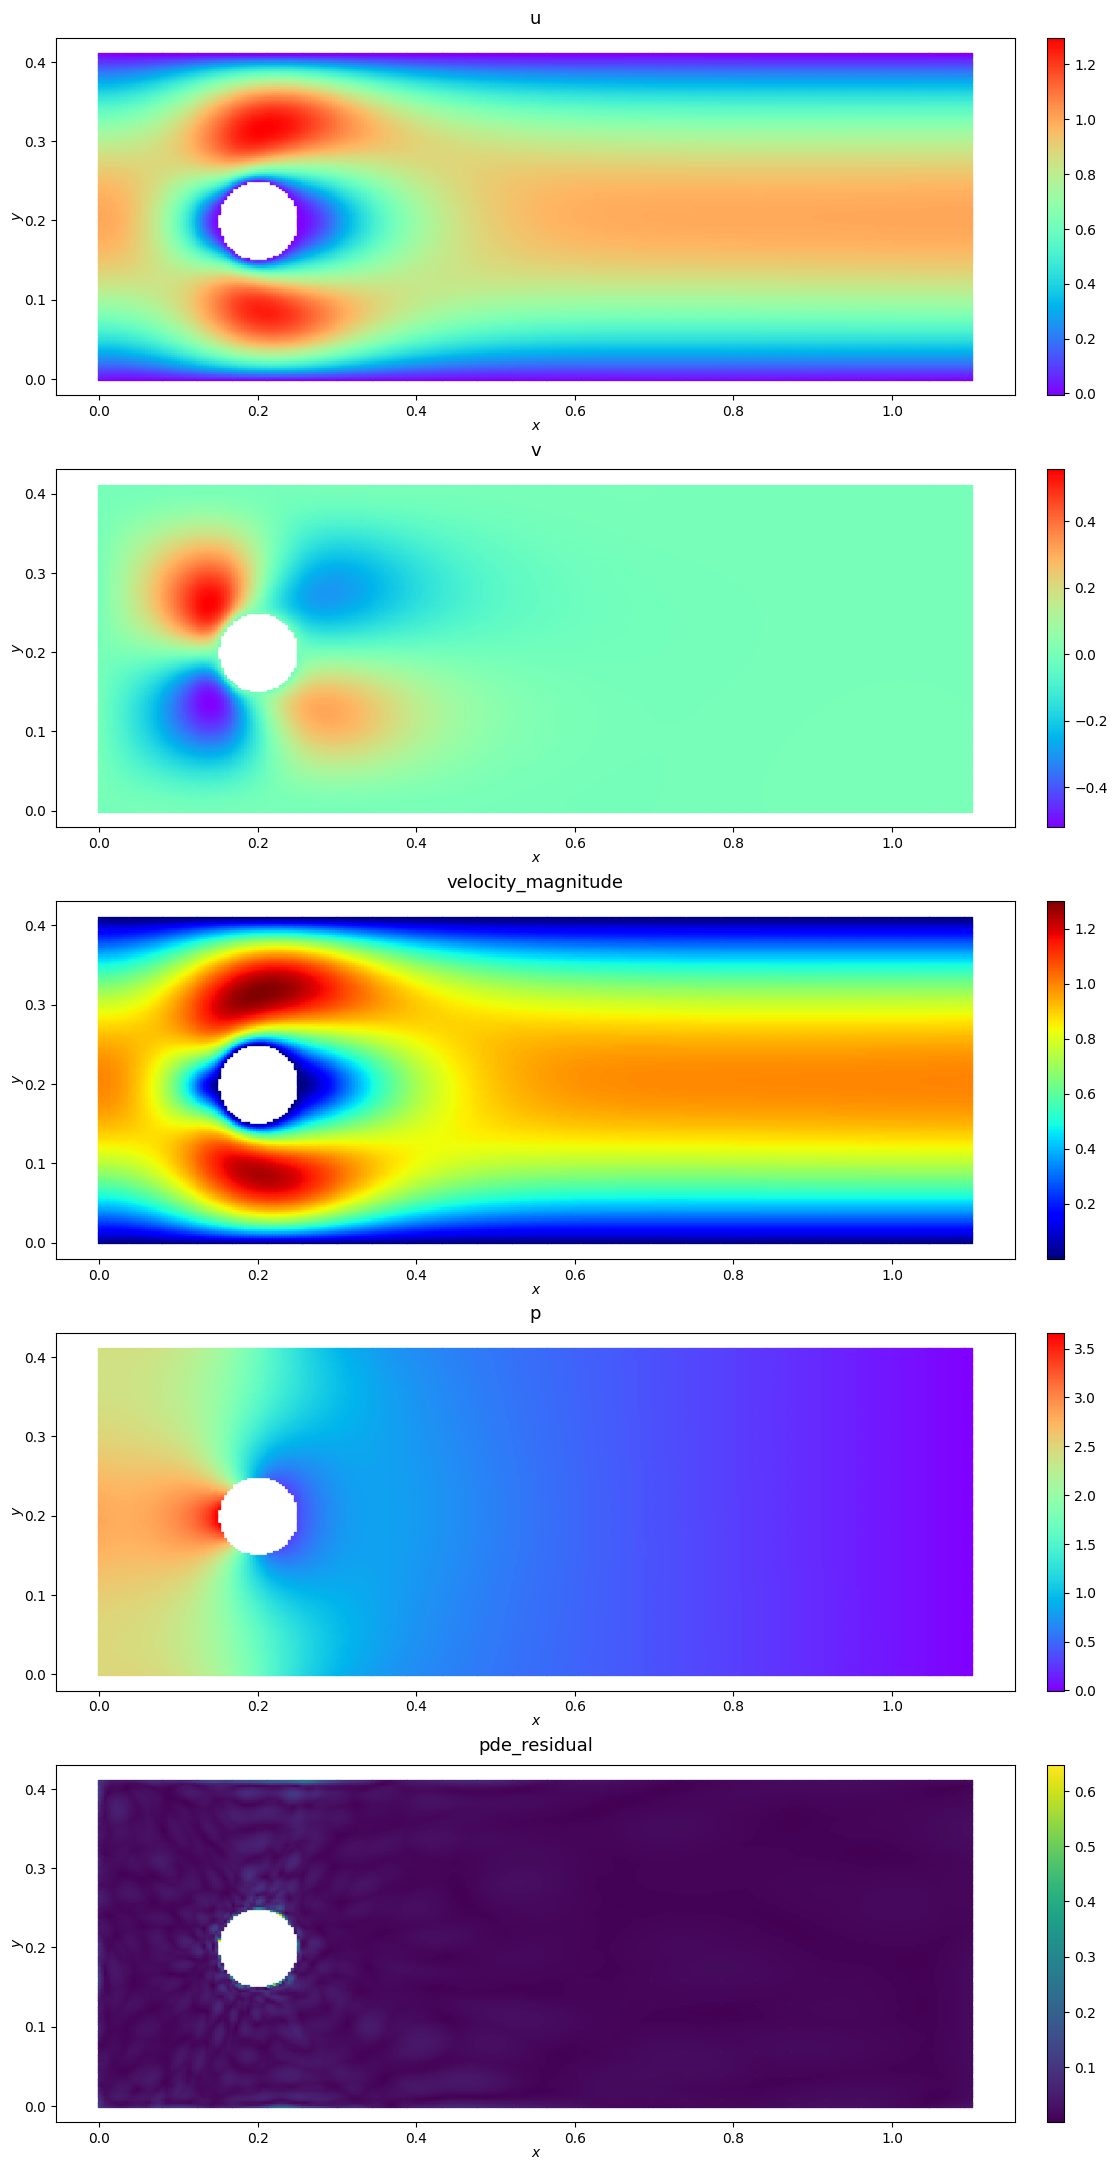

In [14]:
cmap_dict = {
    'u':'rainbow',
    'v':'rainbow',
    'velocity_magnitude': 'jet',
    'p':'rainbow',
    'pde_residual': 'viridis'}
colorplot_area_2d = area_eval.plot_color(cmap_dict, s=2).savefig("colorplot_2d")

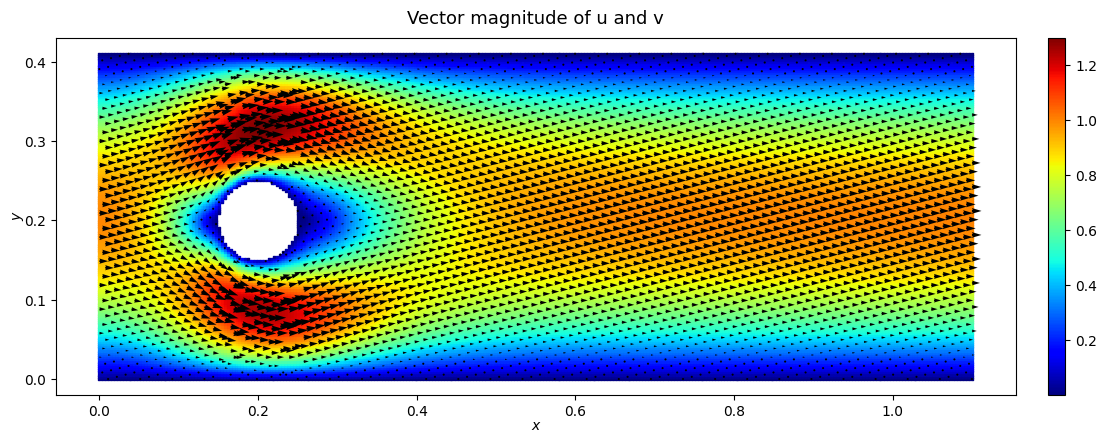

In [22]:
_ = area_eval.plot_vector(u='u', v='v', scale=100, cmap='jet')

[('pde_residual', 'viridis')]


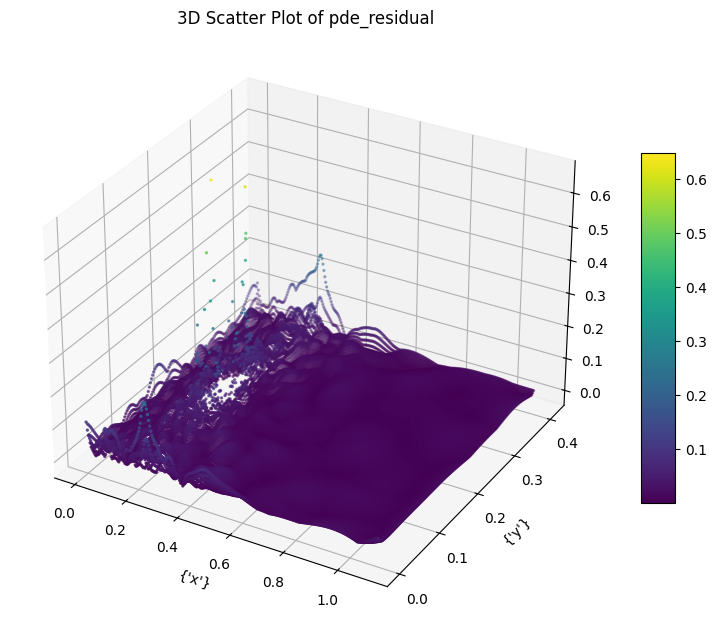

In [23]:
residual_plot_3d = area_eval.plot('pde_residual').savefig("residual_plot_3d.png")

### 4.2 Visualize bound

In [17]:
# Create object for evaluation
bound_visual = domain.bound_list[2].evaluate(model2)
# Sampling uniform points
bound_visual.sampling_line(100)

C:\Users\thamm\OneDrive\Documents\1 - Projects\0 - STEM\2 - Numerical Physics\9 - PINNs\deepflow\src\deepflow\visualization.py:51: RuntimeWarning: divide by zero encountered in scalar divide
  try: ratio = np.ptp(Y) / np.ptp(X)


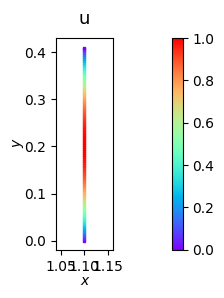

In [18]:
colorplot_bound = bound_visual.plot_color({'u':'rainbow'}).savefig("colorplot_bound.png")

[('u', 'blue')]


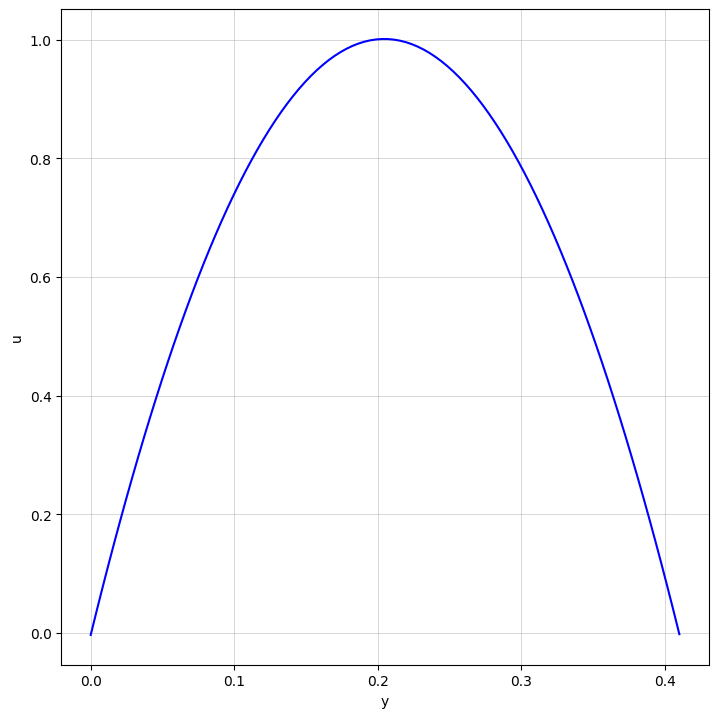

In [19]:
velocity_plot_outlet = bound_visual.plot(x_axis = 'y', y_axis={'u':'blue'})

## 4.3 Visualize Neural Network data

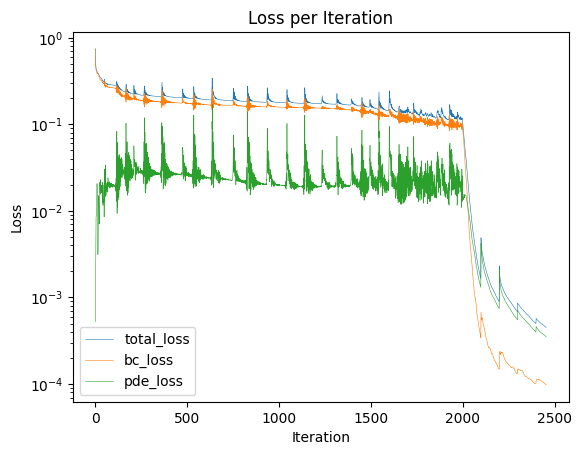

In [20]:
loss_history = bound_visual.plot_loss_curve(log_scale=True, linewidth=0.4).savefig("loss_history.png")

### 4.4 Export data

In [21]:
# store the x,y,velocity_magnitude data
x_data = bound_visual.data_dict['x']
y_data = bound_visual.data_dict['y']
u_data = bound_visual.data_dict['u']

#save as txt file
import numpy as np
array = np.column_stack((x_data, y_data, u_data))
np.savetxt('outlet_velocity.txt', array)